## Avance 2. Ingeniería de características

SAntes de comenzar con el proceso de ingenieria de caracteristicas, se desarrolla una clase de base de datos de pytorch para importar las matrices de entrada y salida

In [1]:
import numpy as np
import os
from scipy.interpolate import griddata
import numpy as np
from torchvision import transforms
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from PIL import Image

In [2]:
# funcion para importar y transformar la martriz de estres

def read(filename):
    x_list, y_list, stresses = [], [], []
    
    with open(filename, 'r') as f:
        next(f)  # Skip header
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 5:
                continue
            # Extract and clean X, Y values (handle trailing dots)
            x = float(parts[1].rstrip('.'))
            y = float(parts[2].rstrip('.'))
            stress = float(parts[4])
            x_list.append(x)
            y_list.append(y)
            stresses.append(stress)
    

    scaling = 4
    
    # Scale coordinates to integers
    scaled_x = [int(round(x * scaling)) for x in x_list]
    scaled_y = [int(round(y * scaling)) for y in y_list]
    
    # Create mappings from unique scaled coordinates to indices
    unique_x = sorted(set(scaled_x))
    unique_y = sorted(set(scaled_y))
    x_to_idx = {x: idx for idx, x in enumerate(unique_x)}
    y_to_idx = {y: idx for idx, y in enumerate(unique_y)}
    
    # Initialize matrix with NaNs
    matrix = np.full((len(unique_y), len(unique_x)), np.nan)
    
    # Populate the matrix with stress values
    for x, y, stress in zip(scaled_x, scaled_y, stresses):
        xi = x_to_idx[x]
        yi = y_to_idx[y]
        if matrix[yi, xi] is np.nan:
            matrix[yi, xi] = stress
        else:
            matrix[yi, xi]= (matrix[yi, xi] + stress) / 2
            
    # Prepare grid coordinates for interpolation
    grid_x, grid_y = np.meshgrid(unique_x, unique_y)
    points = np.array([[x, y] for x, y in zip(scaled_x, scaled_y)])
    values = np.array(stresses)
    
    # Interpolate missing values
    filled_matrix = griddata(points, values, (grid_x, grid_y), method='linear')
    flipped_matrix = filled_matrix[::-1, :].copy()


    return flipped_matrix


In [3]:

class StressDataset(Dataset):
    def __init__(self, root_folder, transform=None):

        self.root_folder = root_folder
        self.transform = transform

        # Collect folder paths and labels from each subfolder
        self.data = []
        for folder_name in sorted(os.listdir(root_folder), key=lambda x: int(x)):
            folder_path = os.path.join(root_folder, folder_name)
            if os.path.isdir(folder_path):
                # Image and text file in the subfolder
                image_path = os.path.join(folder_path, "image.png")
                label_path = os.path.join(folder_path, "data2.txt")

                # Ensure both files exist
                if os.path.exists(image_path) and os.path.exists(label_path):
                    # Use the provided `read` function to process the label
                    stress_array = read(label_path)
                    self.data.append((image_path, stress_array))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image path and stress grid
        image_path, stress_grid = self.data[idx]

        # Open the image
        image = Image.open(image_path).convert("L")  # Convert to grayscale
        #convert stress grid np to pil obj
        stress_grid = Image.fromarray(stress_grid)
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
            stress_grid=self.transform(stress_grid)
        else:
            image = transforms.ToTensor()(image)  # Default transformation to tensor
            stress_grid=transforms.ToTensor()(stress_grid) 


        return image, stress_grid


In [4]:

# Path to the root folder containing subfolders
root_folder = "db/random/"

# Define transformations (e.g., resize images, normalize them, etc.)
transform_pipeline = transforms.Compose([
    transforms.Resize((126, 126)),  # Resize to 128x128 pixels
    transforms.ToTensor()          # Convert to a PyTorch tensor
])

# Create an instance of the dataset
dataset = StressDataset(root_folder=root_folder, transform=transform_pipeline)

Una vez importada la base de datos esta lista para ser explorada

Se visualiza un ejemplo de la mascara de entrada al modelo y la predicion de estres de una pieza

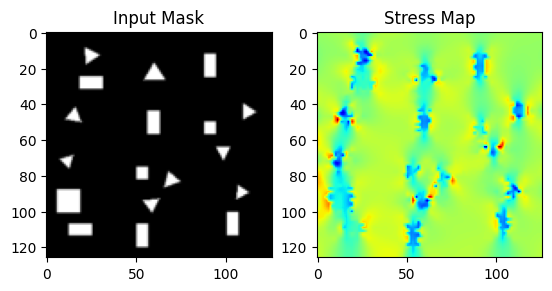

In [5]:

i=26
in_=dataset[i][0][0,:,:]
out=dataset[i][1][0,:,:]
#plot 2x1 grid
fig, axs = plt.subplots(1, 2)
axs[0].imshow(in_, cmap='gray')
axs[0].set_title('Input Mask')
axs[1].imshow(out, cmap='jet')
axs[1].set_title('Stress Map')
plt.show()


Ahora que la base de datos de mascaras y simulaciones de estres esta cargada correctamente, es posible iniciar el proceso de ingenieria de caracteriscas

#### a) Se aplicarán operaciones comunes para convertir los datos crudos del mundo real, en un conjunto de variables útiles para el aprendizaje automático.

Tres indiadores importantes puedes ser facilmente extraidos del mapa de estres, estos son, estres minimo, maximo y promedio

In [6]:
min_stress_list = []
max_stress_list = []
mean_stress_list = []

for i in range(len(dataset)):
    stress_map = dataset[i][1][0,:,:]
    min_stress_list.append(stress_map.min())
    max_stress_list.append(stress_map.max())
    mean_stress_list.append(stress_map.mean())

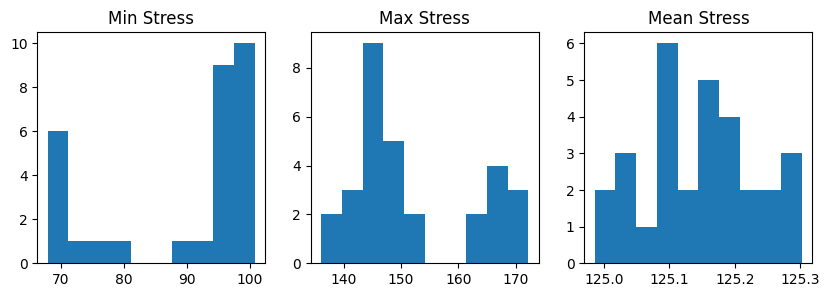

In [7]:
#visualize the distribution of the min, max and mean stress values
fig, axs = plt.subplots(1, 3)
axs[0].hist(min_stress_list)
axs[0].set_title('Min Stress')
axs[1].hist(max_stress_list)
axs[1].set_title('Max Stress')
axs[2].hist(mean_stress_list)
axs[2].set_title('Mean Stress')

fig.set_size_inches(10, 3)
plt.show()


Para explorar los datos de entrada(mascaras) la siguiente tecnias de manera que podamos extraer informacion de valor de las mascaras que posteriormente faciliten el entrenamiento de un modelo.

 - Escoletonizacion
 - Deteccion y medicion de bordes
 - calculo de fraccion de inclusiones

Esceletonizacion

Esta transformacion puede aportar valor porque los píxeles cercanos a los límites en la máscara pueden experimentar patrones de tensión diferentes a los que están más profundos dentro de una región. La transformación de distancia codifica esta información.

In [8]:
from skimage.morphology import skeletonize

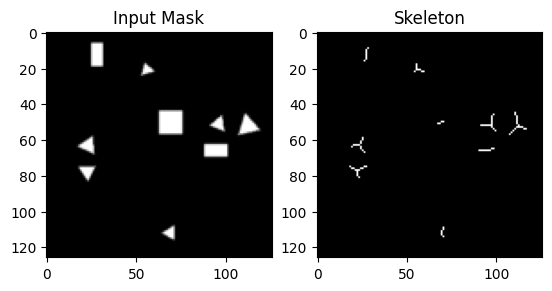

In [9]:
mask=dataset[i][0][0,:,:].numpy()

skel = skeletonize(mask)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(mask, cmap='gray')
axs[0].set_title('Input Mask')
axs[1].imshow(skel, cmap='gray')
axs[1].set_title('Skeleton')
plt.show()


#### b) Se utilizarán métodos de filtrado para la selección de características y técnicas de extracción de características, permitiendo reducir los requerimientos de almacenamiento, la complejidad del modelo y el tiempo de entrenamiento. 

Deteccion y medicion de bordes

La longitud del borde de inclusión puede agregar valor al modelo de predicción de tensión porque proporciona una medida de cuánto interfaz existe entre diferentes fases de material (por ejemplo, inclusiones y la matriz). Esto influye directamente en la distribución de la tensión.

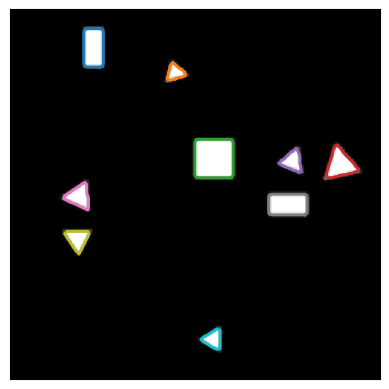

In [10]:
from skimage import measure

mask=dataset[i][0][0,:,:].numpy()
contours = measure.find_contours(mask, level=0.5)

fig, ax = plt.subplots()
ax.imshow(mask, cmap='gray')

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

from skimage import measure
border_lengths = []
for i in range(len(dataset)):
    mask=dataset[i][0][0,:,:].numpy()
    contours = measure.find_contours(mask, level=0.5)

    total_border_length = sum(np.linalg.norm(np.diff(contour, axis=0), axis=1).sum() for contour in contours)
    border_lengths.append(total_border_length)

    


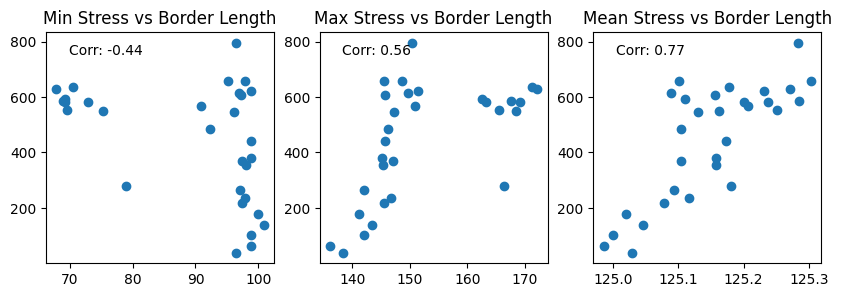

In [11]:
#plotting border length vs min, max, mean stress values
fig, axs = plt.subplots(1, 3)
corr = np.corrcoef(min_stress_list, border_lengths)[0, 1]
axs[0].scatter(min_stress_list, border_lengths)
axs[0].set_title('Min Stress vs Border Length')
axs[0].text(0.1, 0.9, f'Corr: {corr:.2f}', transform=axs[0].transAxes)

corr=np.corrcoef(max_stress_list, border_lengths)[0, 1]
axs[1].scatter(max_stress_list, border_lengths)
axs[1].set_title('Max Stress vs Border Length')
axs[1].text(0.1, 0.9, f'Corr: {corr:.2f}', transform=axs[1].transAxes)

corr=np.corrcoef(mean_stress_list, border_lengths)[0, 1]
axs[2].scatter(mean_stress_list, border_lengths)
axs[2].set_title('Mean Stress vs Border Length')
axs[2].text(0.1, 0.9, f'Corr: {corr:.2f}', transform=axs[2].transAxes)
#plot size
fig.set_size_inches(10,3)
plt.show()

Proporcion de inclusiones

La fracción del área de inclusión (también llamada fracción de volumen en casos 3D) es una característica crucial en la modelización de la distribución de tensión. Describe cuánto del material está ocupado por inclusiones en comparación con la matriz y tiene un efecto directo en las propiedades mecánicas.

In [12]:
#inclusion fraction
inclusion_fractions = []
for i in range(len(dataset)):
    mask=dataset[i][0][0,:,:].numpy()
    inclusion_fraction = mask.sum() / mask.size
    inclusion_fractions.append(inclusion_fraction)

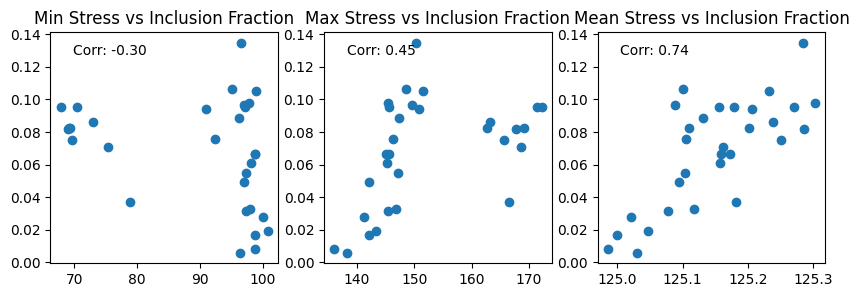

In [13]:
#plotting inclusion fraction vs min, max, mean stress values
fig, axs = plt.subplots(1, 3)
corr = np.corrcoef(min_stress_list, inclusion_fractions)[0, 1]
axs[0].scatter(min_stress_list, inclusion_fractions)
axs[0].set_title('Min Stress vs Inclusion Fraction')
axs[0].text(0.1, 0.9, f'Corr: {corr:.2f}', transform=axs[0].transAxes)

corr=np.corrcoef(max_stress_list, inclusion_fractions)[0, 1]
axs[1].scatter(max_stress_list, inclusion_fractions)
axs[1].set_title('Max Stress vs Inclusion Fraction')
axs[1].text(0.1, 0.9, f'Corr: {corr:.2f}', transform=axs[1].transAxes)

corr=np.corrcoef(mean_stress_list, inclusion_fractions)[0, 1]
axs[2].scatter(mean_stress_list, inclusion_fractions)
axs[2].set_title('Mean Stress vs Inclusion Fraction')
axs[2].text(0.1, 0.9, f'Corr: {corr:.2f}', transform=axs[2].transAxes)

#plot size
fig.set_size_inches(10,3)
plt.show()


Conclusiones
Tecnicas de ingeniera de caracteristicas especificas para vision maquinca fueron utilizadas.

Es posible obersvar que tanto la longitud total de brodes como la fraccion de inclusiones tiene una buena correlacion con el estres promedio de la pieza, lo que puede ser muy util en la etapa de modelado porque reduce la cantidad de informacion de una matriz de 126X126 a una sola variable que por si sola tiene una correlacion de arriba del 0.70 con el estres promedio que se espera de la pieza.

Adicionalmente, el usa de la funcion "skeletonize" puede ser includa durante el entrenamiento del modelo para agregar informacion extra debido a que genera patrones relaciondos con la distancia del centro de las inclusiones con sus bordes y esquinas, que es donde comunmente se concentra el estres de un cuerpo bajo tension.